In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


TASK 1

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 1. Load and preprocess the dataset
file_path = 'kc_house_data.csv'  # Update with your file path
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    raise FileNotFoundError("Dataset not found! Please check the file path.")

# Remove irrelevant columns and keep numerical features
data = data.select_dtypes(include=[np.number])
data = data.drop(columns=['id', 'date'], errors='ignore')

# Separate features (X) and target variable (y)
X = data.drop(columns=['price'])
y = data['price']

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. Define and evaluate neural network models
def build_and_evaluate_nn(input_dim, layers_config, dropout_rate, learning_rate, epochs, X_train, X_test, y_train, y_test):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for neurons in layers_config:
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_split=0.2)
    predictions = model.predict(X_test)
    return r2_score(y_test, predictions), mean_squared_error(y_test, predictions), mean_absolute_error(y_test, predictions)

# Neural network configurations for cross-validation
nn_configs = [
    {'layers': [64, 32], 'dropout': 0.2, 'lr': 0.001, 'epochs': 10},
    {'layers': [128, 64], 'dropout': 0.3, 'lr': 0.001, 'epochs': 20},
    {'layers': [128, 128], 'dropout': 0.2, 'lr': 0.0005, 'epochs': 20}
]

# 5-Fold cross-validation for neural networks
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_nn = []

for config in nn_configs:
    r2_scores, mse_scores, mae_scores = [], [], []
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        r2, mse, mae = build_and_evaluate_nn(
            input_dim=X_train.shape[1],
            layers_config=config['layers'],
            dropout_rate=config['dropout'],
            learning_rate=config['lr'],
            epochs=config['epochs'],
            X_train=X_train_fold, X_test=X_val_fold,
            y_train=y_train_fold, y_test=y_val_fold
        )
        r2_scores.append(r2)
        mse_scores.append(mse)
        mae_scores.append(mae)

    results_nn.append({
        'config': config,
        'R²': np.mean(r2_scores),
        'MSE': np.mean(mse_scores),
        'MAE': np.mean(mae_scores)
    })

# 3. Evaluate Random Forest
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_feature_importances = rf_model.feature_importances_

# 4. Evaluate Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_r2 = r2_score(y_test, lr_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)

# 5. Evaluate Decision Tree
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_r2 = r2_score(y_test, dt_predictions)
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_feature_importances = dt_model.feature_importances_

# 6. Evaluate SVM
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_r2 = r2_score(y_test, svm_predictions)
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_mae = mean_absolute_error(y_test, svm_predictions)

# 7. Evaluate KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_r2 = r2_score(y_test, knn_predictions)
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_mae = mean_absolute_error(y_test, knn_predictions)

# 8. Evaluate XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1, max_depth=5)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_feature_importances = xgb_model.feature_importances_

# 9. Evaluate LightGBM
lgb_model = LGBMRegressor(random_state=42, n_jobs=-1, max_depth=5)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_r2 = r2_score(y_test, lgb_predictions)
lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_mae = mean_absolute_error(y_test, lgb_predictions)
lgb_feature_importances = lgb_model.feature_importances_

# 10. Evaluate CatBoost
cat_model = CatBoostRegressor(verbose=0, random_state=42, thread_count=-1, depth=5)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)
cat_r2 = r2_score(y_test, cat_predictions)
cat_mse = mean_squared_error(y_test, cat_predictions)
cat_mae = mean_absolute_error(y_test, cat_predictions)
cat_feature_importances = cat_model.feature_importances_

# 11. Compile results into a table
results_df = pd.DataFrame({
    'Model': ['Neural Network 1', 'Neural Network 2', 'Neural Network 3', 'Random Forest', 'Linear Regression', 'Decision Tree', 'SVM', 'KNN', 'XGBoost', 'LightGBM', 'CatBoost'],
    'R²': [results_nn[0]['R²'], results_nn[1]['R²'], results_nn[2]['R²'], rf_r2, lr_r2, dt_r2, svm_r2, knn_r2, xgb_r2, lgb_r2, cat_r2],
    'MSE': [results_nn[0]['MSE'], results_nn[1]['MSE'], results_nn[2]['MSE'], rf_mse, lr_mse, dt_mse, svm_mse, knn_mse, xgb_mse, lgb_mse, cat_mse],
    'MAE': [results_nn[0]['MAE'], results_nn[1]['MAE'], results_nn[2]['MAE'], rf_mae, lr_mae, dt_mae, svm_mae, knn_mae, xgb_mae, lgb_mae, cat_mae]
})

print("\nModel Performance Comparison:")
print(results_df.sort_values(by='R²', ascending=False))

# Feature importance summary
def print_feature_importances(model_name, importances, feature_names):
    print(f"\nFeature Importances for {model_name}:")
    for name, importance in zip(feature_names, importances):
        print(f"{name}: {importance:.4f}")

feature_names = X.columns
print_feature_importances("Random Forest", rf_feature_importances, feature_names)
print_feature_importances("Decision Tree", dt_feature_importances, feature_names)
print_feature_importances("XGBoost", xgb_feature_importances, feature_names)
print_feature_importances("LightGBM", lgb_feature_importances, feature_names)
print_feature_importances("CatBoost", cat_feature_importances, feature_names)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 17290, number of used features: 18
[LightGBM] [Info] Start training from score 537768.047947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Model Performance Comparison:
                Model        R²           MSE            MAE
10           CatBoost  0.896512  1.564504e+10   67345.116106
9            LightGBM  0.873225  1.916539e+10   74741.810905
8             XGBoost  0.864370  2.050407e+10   70803.362675
3       Random Forest  0.838104  2.447498e+10   79880.344344
7                 KNN  0.787404  3.213949e+10   90067.744992
5       Decision Tree  0.745518  3.847169e+10   96786.688326
4   Linear Regression  0.701190  4.517305e+10  127493.342087
1    Neural Network 2  0.407374  7.758651e+10  172971.977757
2    Neural Network 3  0.322745  8.864216e+10  188310.275665
0    Neural Network 1  0.213260  1.025363e+11  188011.999028
6                 SVM -0.062920  1.606887e+11  229324.358147

Feature Importances for Random Forest:
bedrooms: 0.0018
bathrooms: 0.0099
sqft_living: 0.2893
sqft_lot: 0.0086
floors: 0.0011
waterfront: 0.0342
view: 0.0095
condition: 0.0013
grade: 0.3369
sqft_above: 0.0135
sqft_basement: 0.0035
yr_bu

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
136/136 ━━━━━━━━

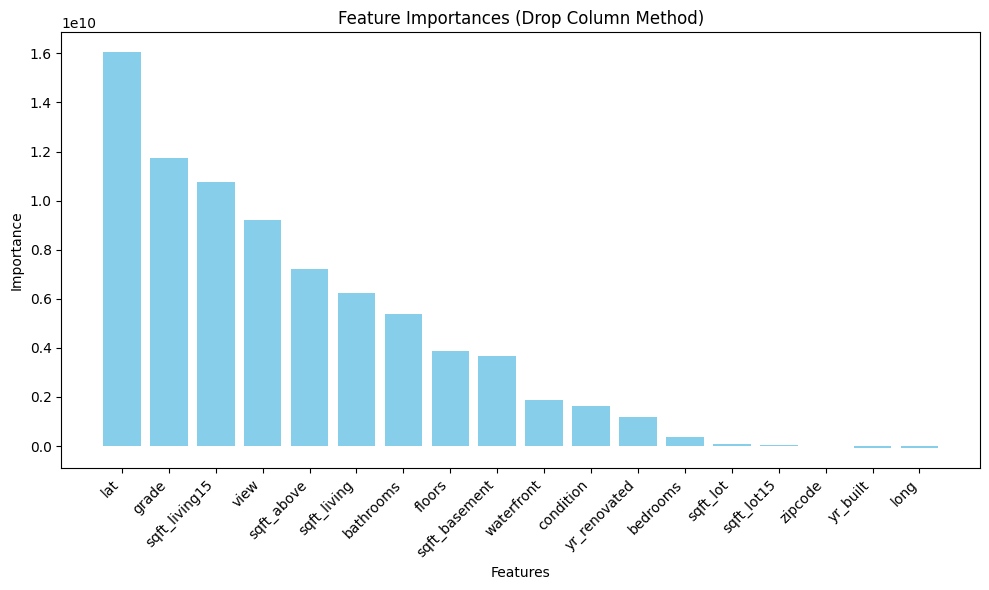

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define the Drop Column Importance method
def drop_column_importance(model, X_test, y_test, feature_names, n_iterations=10):

    original_predictions = model.predict(X_test)
    original_mse = mean_squared_error(y_test, original_predictions)

    feature_importances = []
    for i, feature in enumerate(feature_names):
        drop_mse_scores = []
        for _ in range(n_iterations):
            X_test_dropped = X_test.copy()
            X_test_dropped[:, i] = 0  # Drop the feature by setting it to 0
            dropped_predictions = model.predict(X_test_dropped)
            drop_mse = mean_squared_error(y_test, dropped_predictions)
            drop_mse_scores.append(drop_mse - original_mse)

        feature_importances.append(np.mean(drop_mse_scores))

    return feature_importances

# Calculate feature importances for the best Neural Network model
best_nn_config = {'layers': [128, 64], 'dropout': 0.3, 'lr': 0.001, 'epochs': 20}
best_nn_model = Sequential()  # Define the model again if needed
best_nn_model.add(Input(shape=(X_train.shape[1],)))
for neurons in best_nn_config['layers']:
    best_nn_model.add(Dense(neurons, activation='relu'))
    best_nn_model.add(Dropout(best_nn_config['dropout']))
best_nn_model.add(Dense(1, activation='linear'))
best_nn_model.compile(optimizer=Adam(learning_rate=best_nn_config['lr']), loss='mse', metrics=['mae'])

# Train the best NN model
best_nn_model.fit(X_train, y_train, epochs=best_nn_config['epochs'], verbose=0, validation_split=0.2)

# Compute feature importances
feature_importances = drop_column_importance(best_nn_model, X_test, y_test, X.columns, n_iterations=10)

# Display feature importances as a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances (Drop Column Method):")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importances (Drop Column Method)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Feature Importances (Permutation Importance Method):
          Feature    Importance
14            lat  2.727767e+06
16  sqft_living15  2.582444e+06
6            view  2.456946e+06
8           grade  2.455231e+06
9      sqft_above  2.010871e+06
4          floors  2.008146e+06
1       bathrooms  1.838930e+06
2     sqft_living  1.734062e+06
10  sqft_basement  9.985766e+05
11       yr_built  6.957544e+05
12   yr_renovated  6.565771e+05
5      waterfront  4.836550e+05
0        bedrooms  3.037911e+05
7       condition  1.804345e+05
15           long  1.626941e+05
17     sqft_lot15  8.496733e+04
3        sqf

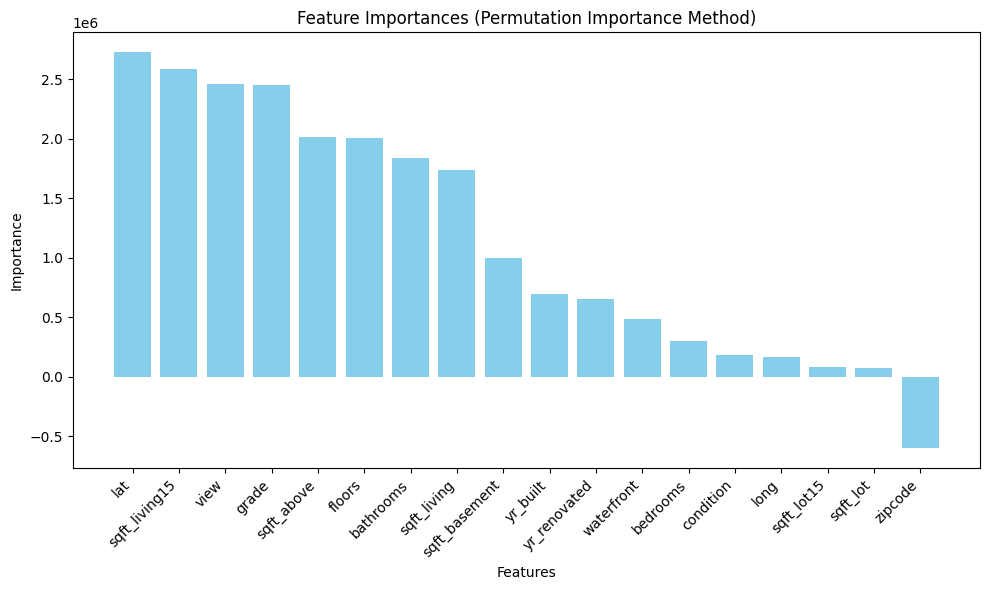

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define the best NN configuration
best_nn_config = {'layers': [128, 64], 'dropout': 0.3, 'lr': 0.001, 'epochs': 5}  # Reduced epochs

def build_nn(input_dim, config):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for neurons in config['layers']:
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(config['dropout']))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=config['lr']), loss='mse', metrics=['mae'])
    return model

# Define a wrapper class compatible with sklearn
class NNWrapper:
    def __init__(self, input_dim, config):
        self.input_dim = input_dim
        self.config = config
        self.model = None

    def fit(self, X, y):
        self.model = build_nn(self.input_dim, self.config)
        self.model.fit(X, y, epochs=self.config['epochs'], batch_size=256, verbose=0, validation_split=0.2)

    def predict(self, X):
        return self.model.predict(X).flatten()

# Subsample the data for faster computation
X_sampled, _, y_sampled, _ = train_test_split(X_scaled, y, test_size=0.5, random_state=42)

# Permutation Importance method
n_splits = 10
n_repeats = 10
feature_importances = np.zeros(X_sampled.shape[1])

for i in range(n_splits):
    # Split data
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_sampled, y_sampled, test_size=0.2, random_state=i
    )

    # Build and train the model
    nn_model = NNWrapper(X_train_split.shape[1], best_nn_config)
    nn_model.fit(X_train_split, y_train_split)

    # Compute permutation importance
    perm_importance = permutation_importance(
        nn_model, X_test_split, y_test_split,
        n_repeats=n_repeats, random_state=42, scoring='neg_mean_squared_error', n_jobs=-1
    )
    feature_importances += perm_importance.importances_mean

# Average feature importances over splits
feature_importances /= n_splits

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances (Permutation Importance Method):")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importances (Permutation Importance Method)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()



Coefficients of the Linear Regression Model (Averaged over 10 splits):
          Feature   Coefficient
8           grade  1.141133e+06
9      sqft_above  1.046939e+06
2     sqft_living  8.702319e+05
5      waterfront  5.789492e+05
10  sqft_basement  4.113041e+05
14            lat  3.760603e+05
1       bathrooms  3.217533e+05
3        sqft_lot  2.106726e+05
6            view  2.101391e+05
16  sqft_living15  1.301121e+05
7       condition  1.052394e+05
12   yr_renovated  4.366553e+04
4          floors  2.118052e+04
13        zipcode -1.140225e+05
15           long -2.551581e+05
11       yr_built -3.021197e+05
17     sqft_lot15 -3.281407e+05
0        bedrooms -1.150179e+06


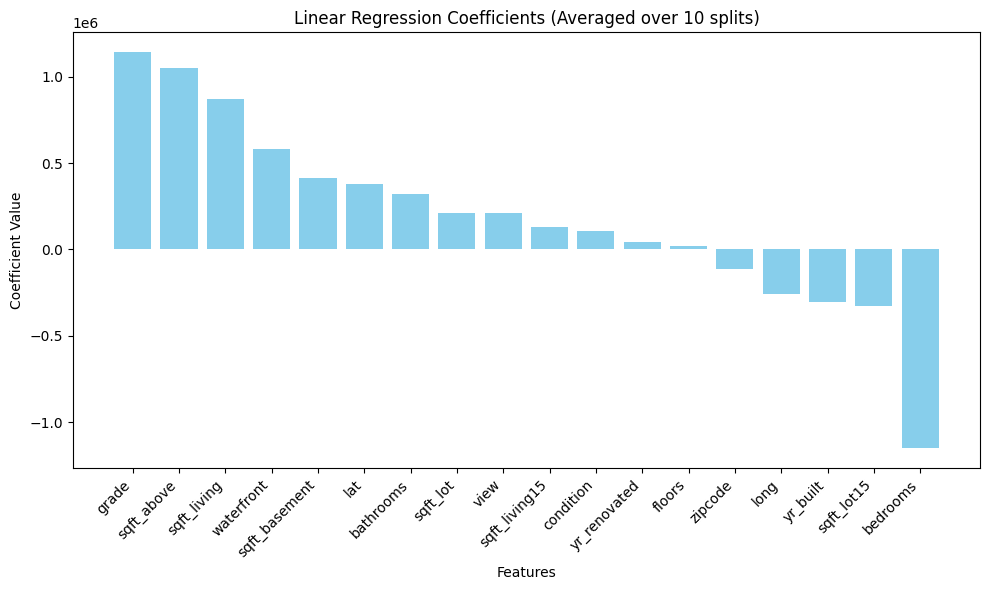

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Initialize variables
n_splits = 10  # Number of splits for averaging coefficients
coefficients = np.zeros(X.shape[1])

# Perform multiple splits and calculate coefficients
for i in range(n_splits):
    # Split the data
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_scaled, y, test_size=0.2, random_state=i
    )

    # Train Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train_split, y_train_split)

    # Accumulate coefficients
    coefficients += lr_model.coef_

# Average coefficients over splits
coefficients /= n_splits

# Create a DataFrame for coefficients
lr_coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print("\nCoefficients of the Linear Regression Model (Averaged over 10 splits):")
print(lr_coefficients_df)

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.bar(lr_coefficients_df['Feature'], lr_coefficients_df['Coefficient'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Linear Regression Coefficients (Averaged over 10 splits)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()



Feature Importances (XGBoost Built-in Method):
          Feature  Importance
8           grade    0.370256
5      waterfront    0.183437
2     sqft_living    0.155065
14            lat    0.075593
6            view    0.044556
15           long    0.041774
11       yr_built    0.020256
16  sqft_living15    0.019636
13        zipcode    0.016957
1       bathrooms    0.014430
9      sqft_above    0.012912
7       condition    0.008508
12   yr_renovated    0.008224
10  sqft_basement    0.007681
3        sqft_lot    0.006840
17     sqft_lot15    0.006003
4          floors    0.004894
0        bedrooms    0.002979


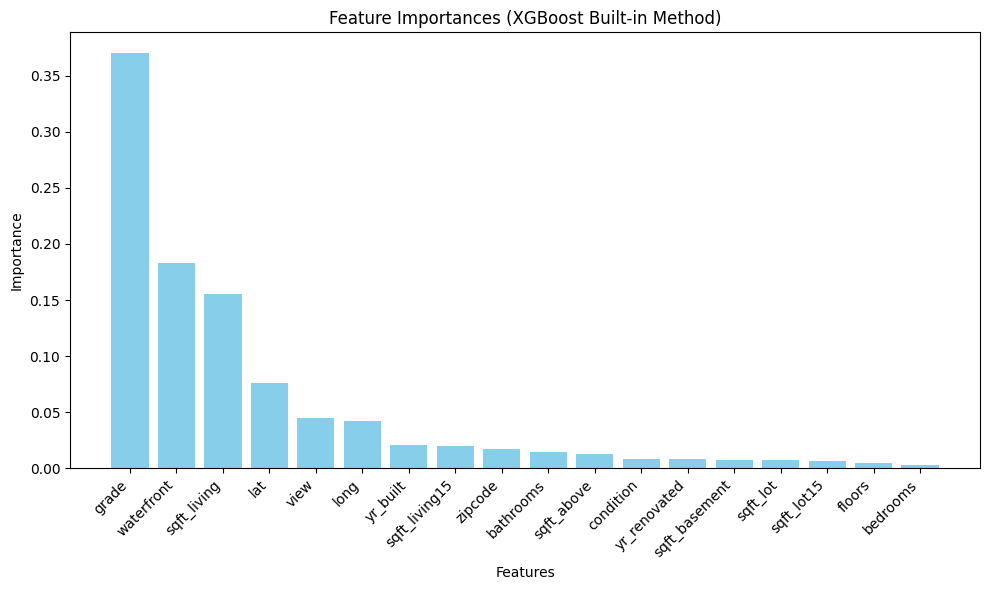

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Define the XGBoost configuration
xgb_config = {'max_depth': 5, 'n_estimators': 100, 'random_state': 42}

# Initialize feature importance array
feature_importances = np.zeros(X.shape[1])

# Number of splits
n_splits = 10

for i in range(n_splits):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=i)

    # Train the XGBoost model
    xgb_model = XGBRegressor(max_depth=xgb_config['max_depth'],
                              n_estimators=xgb_config['n_estimators'],
                              random_state=xgb_config['random_state'])
    xgb_model.fit(X_train, y_train)

    # Add feature importances
    feature_importances += xgb_model.feature_importances_

# Average feature importances over splits
feature_importances /= n_splits

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Output the results
print("\nFeature Importances (XGBoost Built-in Method):")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importances (XGBoost Built-in Method)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


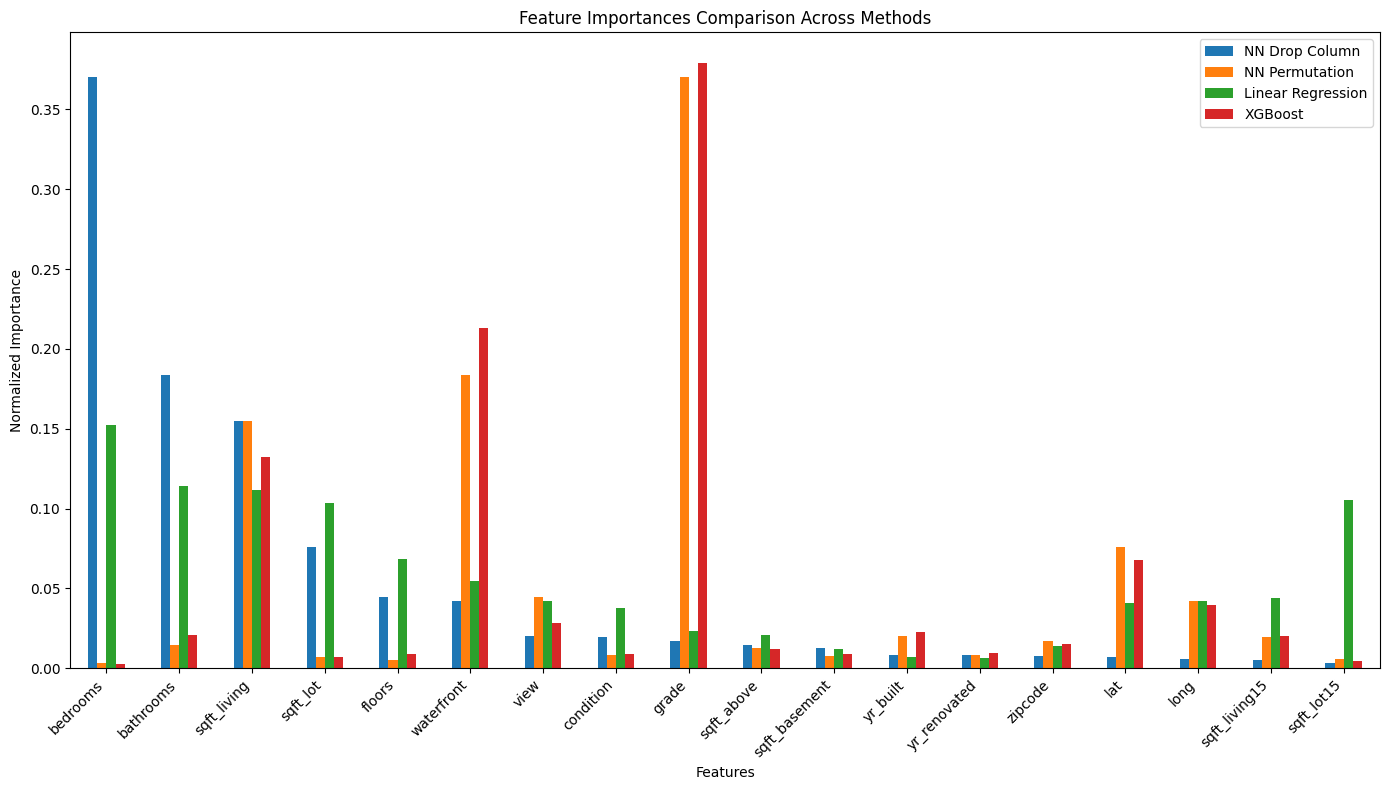

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Normalization Function
def normalize_importances(importances):
    return importances / np.sum(importances)

# NN Drop Column Importance (example values, replace with actual data)
nn_drop_importances = normalize_importances(np.abs(feature_importance_df['Importance'].values))

# NN Permutation Importance (example values, replace with actual data)
nn_perm_importances = normalize_importances(feature_importances)

# Linear Regression Coefficients (example values, replace with actual data)
lr_coefficients = normalize_importances(np.abs(lr_coefficients_df['Coefficient'].values))

# XGBoost Feature Importances (example values, replace with actual data)
xgb_importances = normalize_importances(xgb_feature_importances)

# Step 2: Combine All Importances Data
importance_comparison = pd.DataFrame({
    'Feature': X.columns,
    'NN Drop Column': nn_drop_importances,
    'NN Permutation': nn_perm_importances,
    'Linear Regression': lr_coefficients,
    'XGBoost': xgb_importances
}).set_index('Feature')

# Step 3: Bar Chart for Comparison
importance_comparison.plot(kind='bar', figsize=(14, 8), title='Feature Importances Comparison Across Methods')
plt.ylabel('Normalized Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


TASK 3

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=296e6a280991628b3a0d181c7b4c4eaa0ed4526c2ce195b6221968fdbda4c052
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


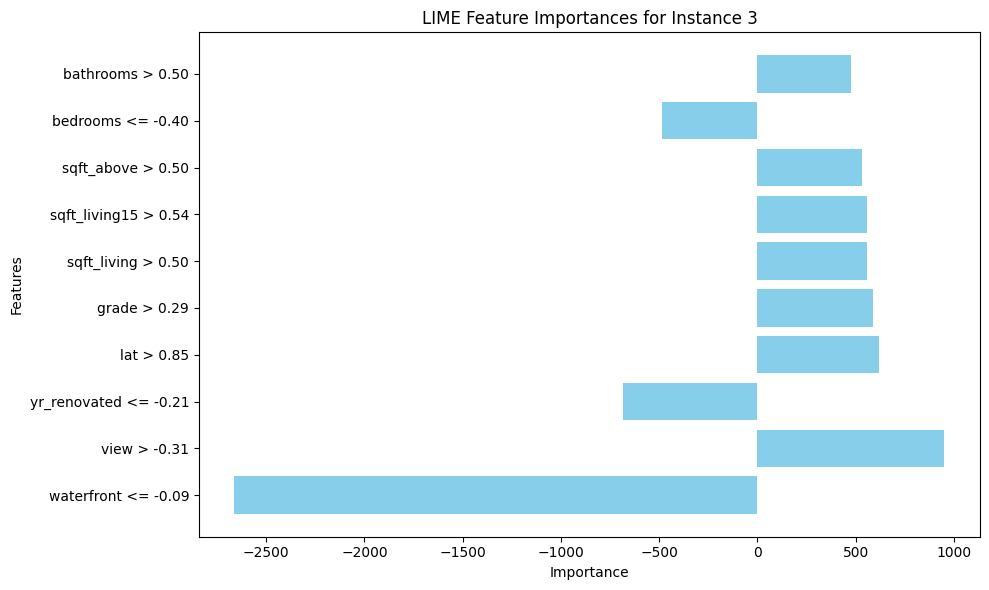

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


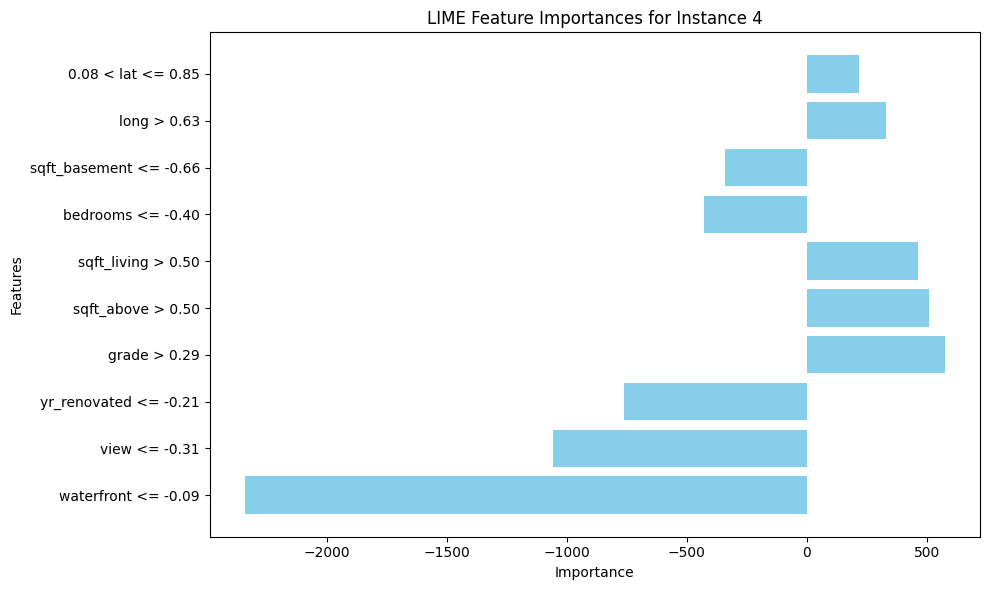

LIME explanations computed and visualized for instances 3 and 4.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define the best NN configuration
best_nn_config = {'layers': [128, 64], 'dropout': 0.3, 'lr': 0.001, 'epochs': 5}

def build_nn(input_dim, config):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for neurons in config['layers']:
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(config['dropout']))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=config['lr']), loss='mse', metrics=['mae'])
    return model

# Step 1: Train-test split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 2: Build and train the NN model
nn_model = build_nn(X_train_split.shape[1], best_nn_config)
nn_model.fit(X_train_split, y_train_split, epochs=best_nn_config['epochs'], batch_size=256, verbose=0, validation_split=0.2)

# Step 3: Initialize LIME Tabular Explainer
explainer = LimeTabularExplainer(
    training_data=X_train_split,
    feature_names=X.columns,
    mode="regression"
)

# Step 4: Select specific instances (3 and 4) for local explainability
instances_to_explain = X_test_split[[3, 4]]

# Step 5: Compute LIME explanations and visualize
for i, instance in enumerate(instances_to_explain):
    explanation = explainer.explain_instance(
        data_row=instance,
        predict_fn=lambda x: nn_model.predict(x).flatten()
    )

    # Extract feature importances
    lime_results = explanation.as_list()
    features, importances = zip(*lime_results)

    # Plot the results as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances, color='skyblue')
    plt.title(f'LIME Feature Importances for Instance {i + 3}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

print("LIME explanations computed and visualized for instances 3 and 4.")


In [ ]:
!pip install scikeras


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━

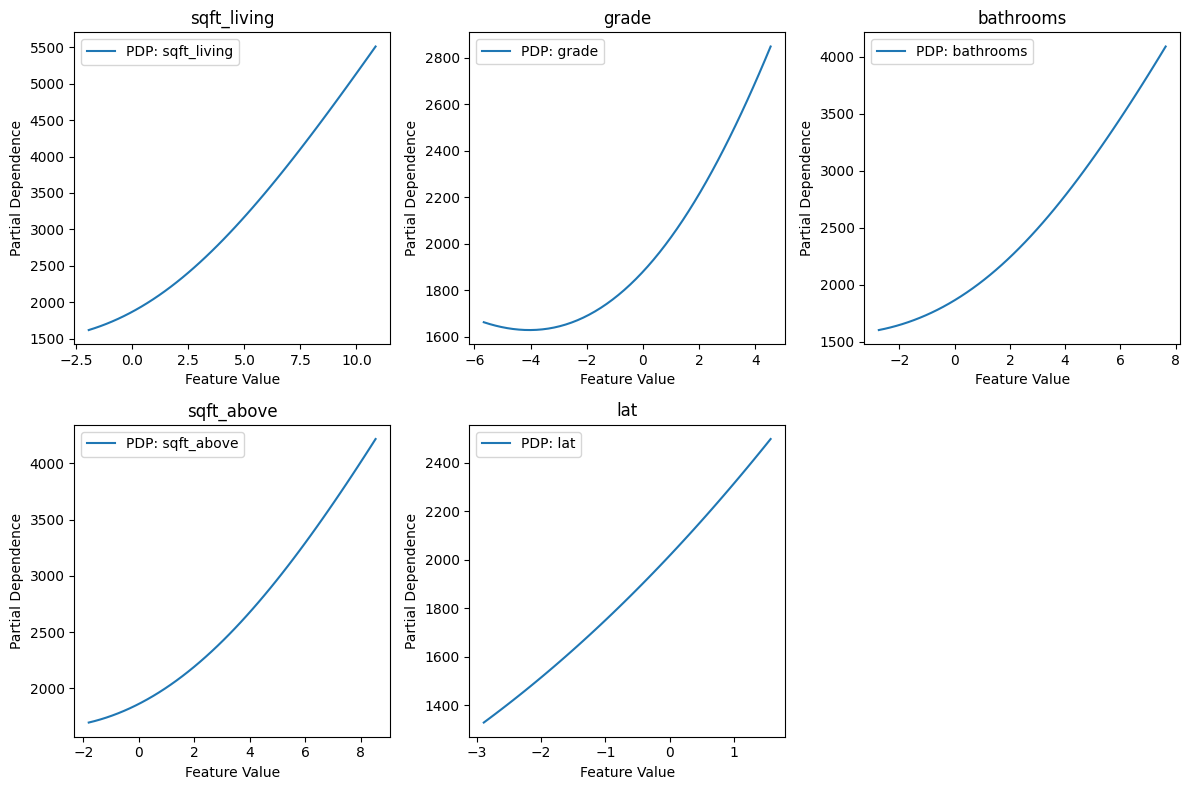

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Step 1: Define the best NN configuration
best_nn_config = {'layers': [128, 64], 'dropout': 0.3, 'lr': 0.001, 'epochs': 5}

def build_nn(input_dim):
    """
    Build a Keras neural network model based on the best configuration.
    """
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for neurons in best_nn_config['layers']:
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(best_nn_config['dropout']))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=best_nn_config['lr']), loss='mse', metrics=['mae'])
    return model

# Step 2: Train-test split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Train the NN model
nn_model = build_nn(X_train_split.shape[1])
nn_model.fit(X_train_split, y_train_split, epochs=best_nn_config['epochs'], batch_size=256, verbose=0, validation_split=0.2)

# Step 4: Compute Partial Dependence Manually
def compute_pdp(model, X, feature_idx, grid_resolution=50):
    """
    Compute Partial Dependence for a single feature.
    """
    feature_values = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), grid_resolution)
    pd_results = []

    for val in feature_values:
        X_temp = X.copy()
        X_temp[:, feature_idx] = val  # Replace the feature column with fixed value
        predictions = model.predict(X_temp, batch_size=256).flatten()
        pd_results.append(predictions.mean())

    return feature_values, pd_results

# Step 5: Generate PDP for the top features
important_features = ['sqft_living', 'grade', 'bathrooms', 'sqft_above', 'lat']  # Adjust based on feature importance
feature_indices = [X.columns.get_loc(f) for f in important_features]

plt.figure(figsize=(12, 8))
for i, feature_index in enumerate(feature_indices):
    plt.subplot(2, 3, i + 1)
    feature_values, pd_results = compute_pdp(nn_model, X_train_split, feature_index)
    plt.plot(feature_values, pd_results, label=f'PDP: {X.columns[feature_index]}')
    plt.title(X.columns[feature_index])
    plt.xlabel('Feature Value')
    plt.ylabel('Partial Dependence')
    plt.legend()
    plt.tight_layout()

plt.show()
